# Apply AI Superresolution to video - Train VDSR from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places
- different blur levels- complete
- different blur levels in the same image
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop
- crop to the super8 resolution 720x480 or video 320x240
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution

## losses
- try l1 loss
- try perceptive loss vgg18

## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation



# Project Documentation

In [1]:

project_base = "/media/SSD/superres/"
results_folder = "Results"
training_folder = "video_data"
model_folder = "checkpoint"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train vdsr with multifuz.ipynb


In [4]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [5]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import os
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
from pathlib import Path
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale

import random
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [6]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [7]:



toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])



In [8]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

In [9]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data",1)

In [10]:
instances

[{'Filepath': '/media/SSD/superres/video_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/102797996.mp4',
  'Type': 'frame',
  'Framenum': 542},
 {'Filepath': '/media/SSD/superres/video_data/114651311.mp4',
  'Type': 'frame',
  

In [11]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [12]:


class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [13]:


class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        
        input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [14]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [37]:


class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, Tophat2DKernel(rand_scale_factor).array)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [38]:
class Crappify(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        k = Tophat2DKernel(int(rand_scale_factor)/2.0).array
        k = k/k.sum()
        
        
        img_cv = cv2.filter2D(img_cv, -1, k)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [39]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [40]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_range, quality_range, slope_range, radius_range, scale_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_range = kernel_range
        self.quality_range = quality_range
        self.slope_range = slope_range
        self.radius_range = radius_range
        self.scale_range = scale_range
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        rand_kernel = random.uniform(*self.kernel_range)
        rand_quality = random.uniform(*self.quality_range)
        rand_slope = random.uniform(*self.slope_range)
        rand_radius = random.uniform(*self.radius_range)*max(height,width)
        

        rand_center = (random.uniform(0,width),random.uniform(0,height))
        
        rand_scale = random.uniform(0.5,2)
        #technically should adjust the scale to the crop size scale of the final image
        
        #blur kernel A
        
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurA = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        #blur kernel B
        rand_kernel = random.uniform(*self.kernel_range)
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurB = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=height, w=width, center=rand_center, radius=rand_radius, scale = rand_scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (height,width,-1))
            alpha=np.broadcast_to(alpha,[height,width,3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        img_cv_blurA = cv2.multiply(img_cv_blurA, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv_blurB = cv2.multiply(img_cv_blurB, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        
        img_cv = cv2.add(img_cv_blurA, img_cv_blurB, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(1280, 720) (1280, 720)


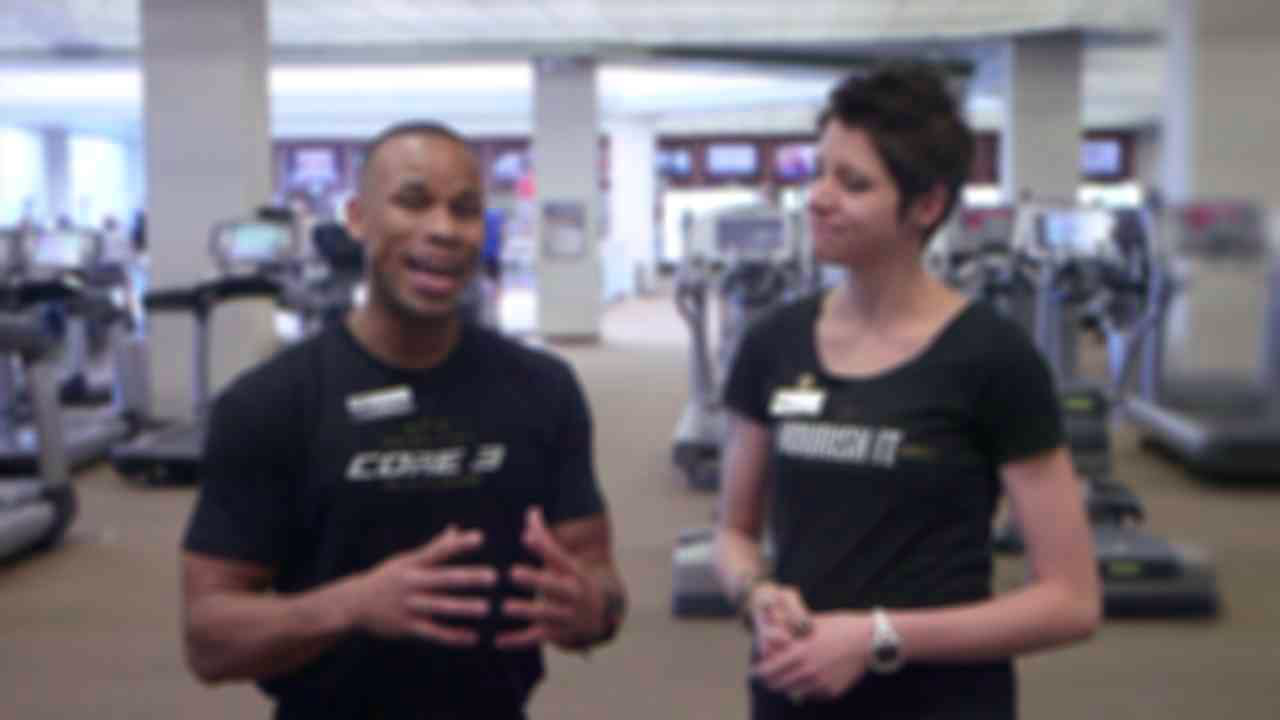

In [46]:
#test the CropRescale transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
#im_res = RescaleCrop(crop_size = (480,720), kernel_width=1)(im)
im_res = Multifuz(crop_size = (720,1280),
                  kernel_range=(4,32), 
                  quality_range=(2,2), 
                  slope_range=(0.00001, 0.001),
                 radius_range=(.05,.75),
                 scale_range=(1/2,2))(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [47]:


def input_transform(crop_size, kernel_range):
    
    
    return Compose([
        
        Multifuz(crop_size = crop_size,
                  kernel_range=kernel_range, 
                  quality_range=(30,90), 
                  slope_range=(0.00001, 0.001),
                 radius_range=(.05,.25),
                 scale_range=(1/2,2)), 
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


def get_training_set(data_dir, crop_size, kernel_range, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, kernel_range),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, kernel_range):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, kernel_range,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, upscale_factor):


    return DatasetFromVideoFolder(data_dir,frame_sample_size=None,
                             input_transform=input_transform(
                                 cropsize, upscale_factor),
                             target_transform=target_transform(cropsize))

In [48]:
train_dir = "/media/SSD/superres/video_data"
frame_sample_size =10
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
kernel_range=(4,20)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [49]:
# create a data set
# split it using random split
# random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))


In [50]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(480, 720)


In [51]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [52]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

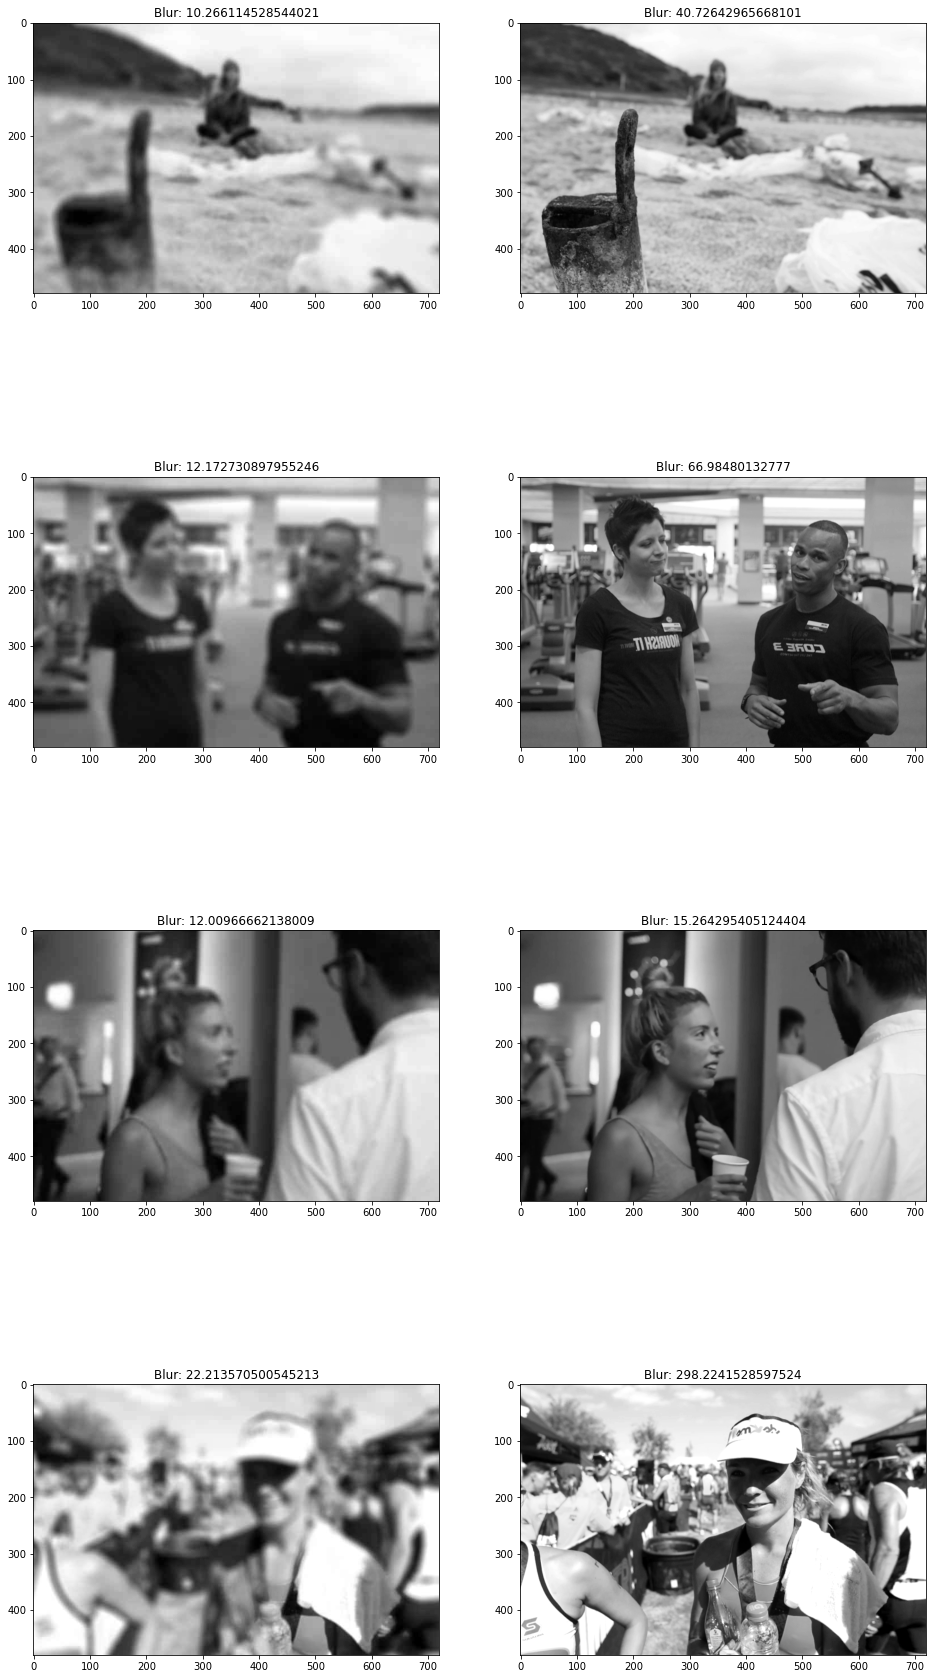

In [54]:
show_batch(training_data_loader,size =8)

# VDSR with dropout

In [ ]:
import torch.nn as nn
from math import sqrt

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.do = nn.Dropout2d(p=0.5, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 18)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out

# Build the model

In [ ]:
model = Net()
model.cuda()


In [55]:
model = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]



/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original sourc

In [ ]:
model

In [30]:
#need to try this
# from https://github.com/xiezw5/Component-Divide-and-Conquer-for-Real-World-Image-Super-Resolution/blob/master/CDC/modules/loss.py

class GradientPenaltyLoss(nn.Module):
    def __init__(self, device=torch.device('cpu')):
        super(GradientPenaltyLoss, self).__init__()
        self.register_buffer('grad_outputs', torch.Tensor())
        self.grad_outputs = self.grad_outputs.to(device)

    def get_grad_outputs(self, input):
        if self.grad_outputs.size() != input.size():
            self.grad_outputs.resize_(input.size()).fill_(1.0)
        return self.grad_outputs

    def forward(self, interp, interp_crit):
        grad_outputs = self.get_grad_outputs(interp_crit)
        grad_interp = torch.autograd.grad(outputs=interp_crit, inputs=interp, \
            grad_outputs=grad_outputs, create_graph=True, retain_graph=True, only_inputs=True)[0]
        grad_interp = grad_interp.view(grad_interp.size(0), -1)
        grad_interp_norm = grad_interp.norm(2, dim=1)

        loss = ((grad_interp_norm - 1)**2).mean()
        return loss

In [56]:
criterion = nn.MSELoss(reduction = 'sum')
#criterion = nn.L1Loss(reduction = 'sum')

In [57]:
#criterion = P_Loss()

#criterion.cuda()

In [58]:
init_lr = 0.1/100
lr_step = 3
gradient_clip = 0.4
epochs = 27

In [59]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)

In [60]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [61]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [62]:
def save_checkpoint(model, epoch):
    model_out_path = "checkpoint/" + "fuzmodel1_epoch_{}.pth".format(epoch)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists("checkpoint/"):
        os.makedirs("checkpoint/")

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

In [63]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [64]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        target = target.cuda()
        
        # Runs the forward pass with autocasting.
        with autocast():
            loss = criterion(model(input), target)
            
        
        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        cum_loss2 = cum_loss2 + loss.data
        ct2=ct2+batch_size
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
    print("Epoch Loss:", cum_loss2/ct2)        

In [66]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(model, epoch)

Start Time: 2020-09-22 20:54:05.208079
Epoch = 1, lr = 0.001
===> Time: 2020-09-22 20:54:17.175851 Epoch[1](10/1586): LR: 0.001 : Loss: 2465.3884277344
===> Time: 2020-09-22 20:54:28.851137 Epoch[1](20/1586): LR: 0.001 : Loss: 9375.1562500000
===> Time: 2020-09-22 20:54:40.661226 Epoch[1](30/1586): LR: 0.001 : Loss: 2476.5209960938
===> Time: 2020-09-22 20:54:52.729336 Epoch[1](40/1586): LR: 0.001 : Loss: 2100.0917968750
===> Time: 2020-09-22 20:55:04.887468 Epoch[1](50/1586): LR: 0.001 : Loss: 1989.6250000000
===> Time: 2020-09-22 20:55:16.681227 Epoch[1](60/1586): LR: 0.001 : Loss: 2069.0314941406
===> Time: 2020-09-22 20:55:28.576858 Epoch[1](70/1586): LR: 0.001 : Loss: 2360.1508789062
===> Time: 2020-09-22 20:55:40.256242 Epoch[1](80/1586): LR: 0.001 : Loss: 1925.0797119141
===> Time: 2020-09-22 20:55:52.164425 Epoch[1](90/1586): LR: 0.001 : Loss: 2191.0810546875
===> Time: 2020-09-22 20:56:04.188951 Epoch[1](100/1586): LR: 0.001 : Loss: 2716.6289062500
===> Time: 2020-09-22 20:56:

===> Time: 2020-09-22 21:11:38.690746 Epoch[1](900/1586): LR: 0.001 : Loss: 2071.9880371094
===> Time: 2020-09-22 21:11:49.985400 Epoch[1](910/1586): LR: 0.001 : Loss: 2264.0131835938
===> Time: 2020-09-22 21:12:01.298885 Epoch[1](920/1586): LR: 0.001 : Loss: 1462.2020263672
===> Time: 2020-09-22 21:12:12.872242 Epoch[1](930/1586): LR: 0.001 : Loss: 2107.4755859375
===> Time: 2020-09-22 21:12:24.326766 Epoch[1](940/1586): LR: 0.001 : Loss: 1830.6746826172
===> Time: 2020-09-22 21:12:35.875140 Epoch[1](950/1586): LR: 0.001 : Loss: 2516.1071777344
===> Time: 2020-09-22 21:12:47.239190 Epoch[1](960/1586): LR: 0.001 : Loss: 1711.3670654297
===> Time: 2020-09-22 21:12:58.533492 Epoch[1](970/1586): LR: 0.001 : Loss: 2198.5688476562
===> Time: 2020-09-22 21:13:09.705283 Epoch[1](980/1586): LR: 0.001 : Loss: 2623.9926757812
===> Time: 2020-09-22 21:13:21.293465 Epoch[1](990/1586): LR: 0.001 : Loss: 2496.2172851562
===> Time: 2020-09-22 21:13:32.852940 Epoch[1](1000/1586): LR: 0.001 : Loss: 226

===> Time: 2020-09-22 21:28:21.823287 Epoch[2](190/1586): LR: 0.001 : Loss: 1550.5786132812
===> Time: 2020-09-22 21:28:33.225723 Epoch[2](200/1586): LR: 0.001 : Loss: 2304.2753906250
===> Time: 2020-09-22 21:28:44.633068 Epoch[2](210/1586): LR: 0.001 : Loss: 1989.9808349609
===> Time: 2020-09-22 21:28:55.975857 Epoch[2](220/1586): LR: 0.001 : Loss: 2059.2333984375
===> Time: 2020-09-22 21:29:07.223127 Epoch[2](230/1586): LR: 0.001 : Loss: 2464.2539062500
===> Time: 2020-09-22 21:29:18.472624 Epoch[2](240/1586): LR: 0.001 : Loss: 2166.7282714844
===> Time: 2020-09-22 21:29:29.749969 Epoch[2](250/1586): LR: 0.001 : Loss: 2512.9975585938
===> Time: 2020-09-22 21:29:41.138138 Epoch[2](260/1586): LR: 0.001 : Loss: 2064.4331054688
===> Time: 2020-09-22 21:29:52.513410 Epoch[2](270/1586): LR: 0.001 : Loss: 1856.4254150391
===> Time: 2020-09-22 21:30:04.257424 Epoch[2](280/1586): LR: 0.001 : Loss: 2380.6564941406
===> Time: 2020-09-22 21:30:15.706433 Epoch[2](290/1586): LR: 0.001 : Loss: 2930

===> Time: 2020-09-22 21:45:33.296944 Epoch[2](1080/1586): LR: 0.001 : Loss: 2432.4282226562
===> Time: 2020-09-22 21:45:44.414408 Epoch[2](1090/1586): LR: 0.001 : Loss: 1883.8131103516
===> Time: 2020-09-22 21:45:56.126192 Epoch[2](1100/1586): LR: 0.001 : Loss: 2135.3654785156
===> Time: 2020-09-22 21:46:07.914458 Epoch[2](1110/1586): LR: 0.001 : Loss: 2037.4559326172
===> Time: 2020-09-22 21:46:19.333682 Epoch[2](1120/1586): LR: 0.001 : Loss: 2087.9096679688
===> Time: 2020-09-22 21:46:30.658261 Epoch[2](1130/1586): LR: 0.001 : Loss: 1793.0657958984
===> Time: 2020-09-22 21:46:42.037963 Epoch[2](1140/1586): LR: 0.001 : Loss: 1479.6868896484
===> Time: 2020-09-22 21:46:53.542838 Epoch[2](1150/1586): LR: 0.001 : Loss: 2036.5838623047
===> Time: 2020-09-22 21:47:05.029773 Epoch[2](1160/1586): LR: 0.001 : Loss: 2059.2380371094
===> Time: 2020-09-22 21:47:16.545185 Epoch[2](1170/1586): LR: 0.001 : Loss: 2843.4094238281
===> Time: 2020-09-22 21:47:27.634165 Epoch[2](1180/1586): LR: 0.001 :

===> Time: 2020-09-22 22:02:40.035690 Epoch[3](370/1586): LR: 0.001 : Loss: 2047.7593994141
===> Time: 2020-09-22 22:02:51.363374 Epoch[3](380/1586): LR: 0.001 : Loss: 2908.2360839844
===> Time: 2020-09-22 22:03:02.682107 Epoch[3](390/1586): LR: 0.001 : Loss: 1790.3870849609
===> Time: 2020-09-22 22:03:14.030944 Epoch[3](400/1586): LR: 0.001 : Loss: 4266.9589843750
===> Time: 2020-09-22 22:03:25.462950 Epoch[3](410/1586): LR: 0.001 : Loss: 2878.8505859375
===> Time: 2020-09-22 22:03:36.709406 Epoch[3](420/1586): LR: 0.001 : Loss: 1525.0035400391
===> Time: 2020-09-22 22:03:48.420787 Epoch[3](430/1586): LR: 0.001 : Loss: 1638.6250000000
===> Time: 2020-09-22 22:04:00.055602 Epoch[3](440/1586): LR: 0.001 : Loss: 2252.3881835938
===> Time: 2020-09-22 22:04:11.444658 Epoch[3](450/1586): LR: 0.001 : Loss: 2046.1502685547
===> Time: 2020-09-22 22:04:22.716643 Epoch[3](460/1586): LR: 0.001 : Loss: 1831.0910644531
===> Time: 2020-09-22 22:04:34.345160 Epoch[3](470/1586): LR: 0.001 : Loss: 2101

===> Time: 2020-09-22 22:19:37.989388 Epoch[3](1260/1586): LR: 0.001 : Loss: 2171.6679687500
===> Time: 2020-09-22 22:19:49.608170 Epoch[3](1270/1586): LR: 0.001 : Loss: 2374.7700195312
===> Time: 2020-09-22 22:20:00.888732 Epoch[3](1280/1586): LR: 0.001 : Loss: 1640.0715332031
===> Time: 2020-09-22 22:20:12.167878 Epoch[3](1290/1586): LR: 0.001 : Loss: 3877.3288574219
===> Time: 2020-09-22 22:20:23.527899 Epoch[3](1300/1586): LR: 0.001 : Loss: 1296.4880371094
===> Time: 2020-09-22 22:20:34.930794 Epoch[3](1310/1586): LR: 0.001 : Loss: 2294.7897949219
===> Time: 2020-09-22 22:20:46.369580 Epoch[3](1320/1586): LR: 0.001 : Loss: 2666.0856933594
===> Time: 2020-09-22 22:20:57.528767 Epoch[3](1330/1586): LR: 0.001 : Loss: 1899.4013671875
===> Time: 2020-09-22 22:21:08.734021 Epoch[3](1340/1586): LR: 0.001 : Loss: 1302.2913818359
===> Time: 2020-09-22 22:21:20.039237 Epoch[3](1350/1586): LR: 0.001 : Loss: 1655.3879394531
===> Time: 2020-09-22 22:21:31.455911 Epoch[3](1360/1586): LR: 0.001 :

===> Time: 2020-09-22 22:34:41.469007 Epoch[4](470/1586): LR: 0.00031622776601683794 : Loss: 2017.8146972656
===> Time: 2020-09-22 22:34:52.941334 Epoch[4](480/1586): LR: 0.00031622776601683794 : Loss: 3539.7949218750
===> Time: 2020-09-22 22:35:04.061610 Epoch[4](490/1586): LR: 0.00031622776601683794 : Loss: 3464.2231445312
===> Time: 2020-09-22 22:35:15.468144 Epoch[4](500/1586): LR: 0.00031622776601683794 : Loss: 5044.3076171875
===> Time: 2020-09-22 22:35:26.816086 Epoch[4](510/1586): LR: 0.00031622776601683794 : Loss: 2679.9692382812
===> Time: 2020-09-22 22:35:38.324069 Epoch[4](520/1586): LR: 0.00031622776601683794 : Loss: 3092.8562011719
===> Time: 2020-09-22 22:35:49.846111 Epoch[4](530/1586): LR: 0.00031622776601683794 : Loss: 2174.2331542969
===> Time: 2020-09-22 22:36:01.256901 Epoch[4](540/1586): LR: 0.00031622776601683794 : Loss: 2544.3020019531
===> Time: 2020-09-22 22:36:12.502656 Epoch[4](550/1586): LR: 0.00031622776601683794 : Loss: 2642.0527343750
===> Time: 2020-09-

===> Time: 2020-09-22 22:48:50.623001 Epoch[4](1220/1586): LR: 0.00031622776601683794 : Loss: 2531.8601074219
===> Time: 2020-09-22 22:49:01.869077 Epoch[4](1230/1586): LR: 0.00031622776601683794 : Loss: 1884.4896240234
===> Time: 2020-09-22 22:49:13.325976 Epoch[4](1240/1586): LR: 0.00031622776601683794 : Loss: 1805.3137207031
===> Time: 2020-09-22 22:49:24.652183 Epoch[4](1250/1586): LR: 0.00031622776601683794 : Loss: 3368.9353027344
===> Time: 2020-09-22 22:49:35.727367 Epoch[4](1260/1586): LR: 0.00031622776601683794 : Loss: 2068.2526855469
===> Time: 2020-09-22 22:49:47.081549 Epoch[4](1270/1586): LR: 0.00031622776601683794 : Loss: 1679.9023437500
===> Time: 2020-09-22 22:49:58.566672 Epoch[4](1280/1586): LR: 0.00031622776601683794 : Loss: 2206.8308105469
===> Time: 2020-09-22 22:50:09.947886 Epoch[4](1290/1586): LR: 0.00031622776601683794 : Loss: 2629.7551269531
===> Time: 2020-09-22 22:50:21.121021 Epoch[4](1300/1586): LR: 0.00031622776601683794 : Loss: 1705.1912841797
===> Time:

===> Time: 2020-09-22 23:02:57.288632 Epoch[5](380/1586): LR: 0.00031622776601683794 : Loss: 1332.9033203125
===> Time: 2020-09-22 23:03:08.738449 Epoch[5](390/1586): LR: 0.00031622776601683794 : Loss: 1977.3967285156
===> Time: 2020-09-22 23:03:20.192421 Epoch[5](400/1586): LR: 0.00031622776601683794 : Loss: 1826.1356201172
===> Time: 2020-09-22 23:03:31.757584 Epoch[5](410/1586): LR: 0.00031622776601683794 : Loss: 1564.6641845703
===> Time: 2020-09-22 23:03:43.289975 Epoch[5](420/1586): LR: 0.00031622776601683794 : Loss: 2043.8225097656
===> Time: 2020-09-22 23:03:54.575702 Epoch[5](430/1586): LR: 0.00031622776601683794 : Loss: 3130.6699218750
===> Time: 2020-09-22 23:04:05.742052 Epoch[5](440/1586): LR: 0.00031622776601683794 : Loss: 2253.2243652344
===> Time: 2020-09-22 23:04:16.828253 Epoch[5](450/1586): LR: 0.00031622776601683794 : Loss: 2304.4812011719
===> Time: 2020-09-22 23:04:28.219871 Epoch[5](460/1586): LR: 0.00031622776601683794 : Loss: 2508.2595214844
===> Time: 2020-09-

===> Time: 2020-09-22 23:17:17.741526 Epoch[5](1140/1586): LR: 0.00031622776601683794 : Loss: 3342.7070312500
===> Time: 2020-09-22 23:17:28.937745 Epoch[5](1150/1586): LR: 0.00031622776601683794 : Loss: 1562.5604248047
===> Time: 2020-09-22 23:17:40.214706 Epoch[5](1160/1586): LR: 0.00031622776601683794 : Loss: 1965.5412597656
===> Time: 2020-09-22 23:17:51.612895 Epoch[5](1170/1586): LR: 0.00031622776601683794 : Loss: 2321.8935546875
===> Time: 2020-09-22 23:18:02.932077 Epoch[5](1180/1586): LR: 0.00031622776601683794 : Loss: 2134.3874511719
===> Time: 2020-09-22 23:18:14.257776 Epoch[5](1190/1586): LR: 0.00031622776601683794 : Loss: 1812.0081787109
===> Time: 2020-09-22 23:18:25.626164 Epoch[5](1200/1586): LR: 0.00031622776601683794 : Loss: 1137.9349365234
===> Time: 2020-09-22 23:18:36.859990 Epoch[5](1210/1586): LR: 0.00031622776601683794 : Loss: 2512.8759765625
===> Time: 2020-09-22 23:18:48.303638 Epoch[5](1220/1586): LR: 0.00031622776601683794 : Loss: 1709.5826416016
===> Time:

===> Time: 2020-09-22 23:31:23.225971 Epoch[6](300/1586): LR: 0.00031622776601683794 : Loss: 1594.3330078125
===> Time: 2020-09-22 23:31:34.740396 Epoch[6](310/1586): LR: 0.00031622776601683794 : Loss: 1687.8406982422
===> Time: 2020-09-22 23:31:46.291315 Epoch[6](320/1586): LR: 0.00031622776601683794 : Loss: 2399.1372070312
===> Time: 2020-09-22 23:31:57.606107 Epoch[6](330/1586): LR: 0.00031622776601683794 : Loss: 1592.8773193359
===> Time: 2020-09-22 23:32:08.879253 Epoch[6](340/1586): LR: 0.00031622776601683794 : Loss: 1724.0084228516
===> Time: 2020-09-22 23:32:20.479025 Epoch[6](350/1586): LR: 0.00031622776601683794 : Loss: 2024.5084228516
===> Time: 2020-09-22 23:32:31.935566 Epoch[6](360/1586): LR: 0.00031622776601683794 : Loss: 1846.6701660156
===> Time: 2020-09-22 23:32:43.144609 Epoch[6](370/1586): LR: 0.00031622776601683794 : Loss: 2146.3061523438
===> Time: 2020-09-22 23:32:54.642575 Epoch[6](380/1586): LR: 0.00031622776601683794 : Loss: 1840.7225341797
===> Time: 2020-09-

===> Time: 2020-09-22 23:45:45.956415 Epoch[6](1060/1586): LR: 0.00031622776601683794 : Loss: 1791.5740966797
===> Time: 2020-09-22 23:45:57.414940 Epoch[6](1070/1586): LR: 0.00031622776601683794 : Loss: 1952.3303222656
===> Time: 2020-09-22 23:46:08.877638 Epoch[6](1080/1586): LR: 0.00031622776601683794 : Loss: 2039.3505859375
===> Time: 2020-09-22 23:46:20.247451 Epoch[6](1090/1586): LR: 0.00031622776601683794 : Loss: 3524.4577636719
===> Time: 2020-09-22 23:46:31.647421 Epoch[6](1100/1586): LR: 0.00031622776601683794 : Loss: 1645.2490234375
===> Time: 2020-09-22 23:46:42.842000 Epoch[6](1110/1586): LR: 0.00031622776601683794 : Loss: 1733.1307373047
===> Time: 2020-09-22 23:46:54.126690 Epoch[6](1120/1586): LR: 0.00031622776601683794 : Loss: 5598.3100585938
===> Time: 2020-09-22 23:47:05.606104 Epoch[6](1130/1586): LR: 0.00031622776601683794 : Loss: 2099.3454589844
===> Time: 2020-09-22 23:47:16.996012 Epoch[6](1140/1586): LR: 0.00031622776601683794 : Loss: 1948.3807373047
===> Time:

===> Time: 2020-09-23 00:00:24.230863 Epoch[7](250/1586): LR: 0.0001 : Loss: 2458.9409179688
===> Time: 2020-09-23 00:00:35.445897 Epoch[7](260/1586): LR: 0.0001 : Loss: 2157.0759277344
===> Time: 2020-09-23 00:00:46.939137 Epoch[7](270/1586): LR: 0.0001 : Loss: 2039.4123535156
===> Time: 2020-09-23 00:00:58.103344 Epoch[7](280/1586): LR: 0.0001 : Loss: 2735.8098144531
===> Time: 2020-09-23 00:01:09.539652 Epoch[7](290/1586): LR: 0.0001 : Loss: 2078.5549316406
===> Time: 2020-09-23 00:01:20.863858 Epoch[7](300/1586): LR: 0.0001 : Loss: 1988.5686035156
===> Time: 2020-09-23 00:01:32.200693 Epoch[7](310/1586): LR: 0.0001 : Loss: 3431.3015136719
===> Time: 2020-09-23 00:01:43.736339 Epoch[7](320/1586): LR: 0.0001 : Loss: 1470.5766601562
===> Time: 2020-09-23 00:01:55.119226 Epoch[7](330/1586): LR: 0.0001 : Loss: 2342.3505859375
===> Time: 2020-09-23 00:02:06.190433 Epoch[7](340/1586): LR: 0.0001 : Loss: 1528.1522216797
===> Time: 2020-09-23 00:02:17.558453 Epoch[7](350/1586): LR: 0.0001 :

===> Time: 2020-09-23 00:17:03.215858 Epoch[7](1130/1586): LR: 0.0001 : Loss: 1743.1851806641
===> Time: 2020-09-23 00:17:14.443993 Epoch[7](1140/1586): LR: 0.0001 : Loss: 1753.5623779297
===> Time: 2020-09-23 00:17:25.747562 Epoch[7](1150/1586): LR: 0.0001 : Loss: 1676.1096191406
===> Time: 2020-09-23 00:17:37.030556 Epoch[7](1160/1586): LR: 0.0001 : Loss: 2478.2419433594
===> Time: 2020-09-23 00:17:48.311644 Epoch[7](1170/1586): LR: 0.0001 : Loss: 2301.1159667969
===> Time: 2020-09-23 00:17:59.682812 Epoch[7](1180/1586): LR: 0.0001 : Loss: 2090.5644531250
===> Time: 2020-09-23 00:18:10.996954 Epoch[7](1190/1586): LR: 0.0001 : Loss: 1552.9486083984
===> Time: 2020-09-23 00:18:22.427249 Epoch[7](1200/1586): LR: 0.0001 : Loss: 1941.6806640625
===> Time: 2020-09-23 00:18:33.530102 Epoch[7](1210/1586): LR: 0.0001 : Loss: 2558.6530761719
===> Time: 2020-09-23 00:18:44.530412 Epoch[7](1220/1586): LR: 0.0001 : Loss: 1553.5244140625
===> Time: 2020-09-23 00:18:55.525095 Epoch[7](1230/1586): L

===> Time: 2020-09-23 00:33:22.097167 Epoch[8](410/1586): LR: 0.0001 : Loss: 1583.3172607422
===> Time: 2020-09-23 00:33:33.368838 Epoch[8](420/1586): LR: 0.0001 : Loss: 1489.5666503906
===> Time: 2020-09-23 00:33:44.676628 Epoch[8](430/1586): LR: 0.0001 : Loss: 2352.2224121094
===> Time: 2020-09-23 00:33:55.867250 Epoch[8](440/1586): LR: 0.0001 : Loss: 3240.3884277344
===> Time: 2020-09-23 00:34:07.166521 Epoch[8](450/1586): LR: 0.0001 : Loss: 2373.7470703125
===> Time: 2020-09-23 00:34:18.651543 Epoch[8](460/1586): LR: 0.0001 : Loss: 1519.9670410156
===> Time: 2020-09-23 00:34:30.006019 Epoch[8](470/1586): LR: 0.0001 : Loss: 2653.9355468750
===> Time: 2020-09-23 00:34:41.121046 Epoch[8](480/1586): LR: 0.0001 : Loss: 1981.2584228516
===> Time: 2020-09-23 00:34:52.312477 Epoch[8](490/1586): LR: 0.0001 : Loss: 2203.5415039062
===> Time: 2020-09-23 00:35:03.644508 Epoch[8](500/1586): LR: 0.0001 : Loss: 1953.9586181641
===> Time: 2020-09-23 00:35:14.865531 Epoch[8](510/1586): LR: 0.0001 :

===> Time: 2020-09-23 00:50:04.442043 Epoch[8](1290/1586): LR: 0.0001 : Loss: 1667.5550537109
===> Time: 2020-09-23 00:50:15.982078 Epoch[8](1300/1586): LR: 0.0001 : Loss: 1935.5256347656
===> Time: 2020-09-23 00:50:27.351203 Epoch[8](1310/1586): LR: 0.0001 : Loss: 1546.5112304688
===> Time: 2020-09-23 00:50:38.781248 Epoch[8](1320/1586): LR: 0.0001 : Loss: 2562.2404785156
===> Time: 2020-09-23 00:50:50.238408 Epoch[8](1330/1586): LR: 0.0001 : Loss: 1895.5800781250
===> Time: 2020-09-23 00:51:01.704368 Epoch[8](1340/1586): LR: 0.0001 : Loss: 2232.5788574219
===> Time: 2020-09-23 00:51:13.209883 Epoch[8](1350/1586): LR: 0.0001 : Loss: 3620.9694824219
===> Time: 2020-09-23 00:51:24.669099 Epoch[8](1360/1586): LR: 0.0001 : Loss: 1875.3127441406
===> Time: 2020-09-23 00:51:35.921584 Epoch[8](1370/1586): LR: 0.0001 : Loss: 2146.2485351562
===> Time: 2020-09-23 00:51:47.367257 Epoch[8](1380/1586): LR: 0.0001 : Loss: 2041.9560546875
===> Time: 2020-09-23 00:51:58.709497 Epoch[8](1390/1586): L

===> Time: 2020-09-23 01:06:37.006979 Epoch[9](580/1586): LR: 0.0001 : Loss: 1507.9085693359
===> Time: 2020-09-23 01:06:48.304895 Epoch[9](590/1586): LR: 0.0001 : Loss: 1747.3629150391
===> Time: 2020-09-23 01:06:59.759040 Epoch[9](600/1586): LR: 0.0001 : Loss: 2754.0834960938
===> Time: 2020-09-23 01:07:11.094165 Epoch[9](610/1586): LR: 0.0001 : Loss: 2862.9343261719
===> Time: 2020-09-23 01:07:22.516394 Epoch[9](620/1586): LR: 0.0001 : Loss: 2296.0021972656
===> Time: 2020-09-23 01:07:33.625432 Epoch[9](630/1586): LR: 0.0001 : Loss: 1605.7790527344
===> Time: 2020-09-23 01:07:45.106298 Epoch[9](640/1586): LR: 0.0001 : Loss: 1911.3723144531
===> Time: 2020-09-23 01:07:56.499179 Epoch[9](650/1586): LR: 0.0001 : Loss: 2324.1335449219
===> Time: 2020-09-23 01:08:07.962761 Epoch[9](660/1586): LR: 0.0001 : Loss: 2799.6962890625
===> Time: 2020-09-23 01:08:19.306788 Epoch[9](670/1586): LR: 0.0001 : Loss: 2147.9365234375
===> Time: 2020-09-23 01:08:30.674661 Epoch[9](680/1586): LR: 0.0001 :

===> Time: 2020-09-23 01:23:12.482612 Epoch[9](1460/1586): LR: 0.0001 : Loss: 2081.4379882812
===> Time: 2020-09-23 01:23:23.797514 Epoch[9](1470/1586): LR: 0.0001 : Loss: 1884.1494140625
===> Time: 2020-09-23 01:23:35.236199 Epoch[9](1480/1586): LR: 0.0001 : Loss: 1651.9949951172
===> Time: 2020-09-23 01:23:46.570690 Epoch[9](1490/1586): LR: 0.0001 : Loss: 2505.3693847656
===> Time: 2020-09-23 01:23:58.124831 Epoch[9](1500/1586): LR: 0.0001 : Loss: 2098.5268554688
===> Time: 2020-09-23 01:24:09.366299 Epoch[9](1510/1586): LR: 0.0001 : Loss: 1484.7691650391
===> Time: 2020-09-23 01:24:20.640483 Epoch[9](1520/1586): LR: 0.0001 : Loss: 1696.9377441406
===> Time: 2020-09-23 01:24:32.243904 Epoch[9](1530/1586): LR: 0.0001 : Loss: 1512.4318847656
===> Time: 2020-09-23 01:24:43.716780 Epoch[9](1540/1586): LR: 0.0001 : Loss: 1840.2326660156
===> Time: 2020-09-23 01:24:55.120849 Epoch[9](1550/1586): LR: 0.0001 : Loss: 2597.8022460938
===> Time: 2020-09-23 01:25:06.490638 Epoch[9](1560/1586): L

===> Time: 2020-09-23 01:37:40.370442 Epoch[10](640/1586): LR: 3.16227766016838e-05 : Loss: 1940.4980468750
===> Time: 2020-09-23 01:37:51.695073 Epoch[10](650/1586): LR: 3.16227766016838e-05 : Loss: 2027.5579833984
===> Time: 2020-09-23 01:38:02.938140 Epoch[10](660/1586): LR: 3.16227766016838e-05 : Loss: 2153.7590332031
===> Time: 2020-09-23 01:38:14.365883 Epoch[10](670/1586): LR: 3.16227766016838e-05 : Loss: 3094.3679199219
===> Time: 2020-09-23 01:38:25.899069 Epoch[10](680/1586): LR: 3.16227766016838e-05 : Loss: 2563.5554199219
===> Time: 2020-09-23 01:38:37.194091 Epoch[10](690/1586): LR: 3.16227766016838e-05 : Loss: 1708.7080078125
===> Time: 2020-09-23 01:38:48.496618 Epoch[10](700/1586): LR: 3.16227766016838e-05 : Loss: 1320.4230957031
===> Time: 2020-09-23 01:38:59.892882 Epoch[10](710/1586): LR: 3.16227766016838e-05 : Loss: 2509.0019531250
===> Time: 2020-09-23 01:39:11.384433 Epoch[10](720/1586): LR: 3.16227766016838e-05 : Loss: 1650.8343505859
===> Time: 2020-09-23 01:39:

===> Time: 2020-09-23 01:52:04.090152 Epoch[10](1400/1586): LR: 3.16227766016838e-05 : Loss: 1668.0070800781
===> Time: 2020-09-23 01:52:15.445522 Epoch[10](1410/1586): LR: 3.16227766016838e-05 : Loss: 1900.4531250000
===> Time: 2020-09-23 01:52:26.826982 Epoch[10](1420/1586): LR: 3.16227766016838e-05 : Loss: 1779.2154541016
===> Time: 2020-09-23 01:52:38.710331 Epoch[10](1430/1586): LR: 3.16227766016838e-05 : Loss: 1798.8382568359
===> Time: 2020-09-23 01:52:50.111637 Epoch[10](1440/1586): LR: 3.16227766016838e-05 : Loss: 1884.0214843750
===> Time: 2020-09-23 01:53:01.391683 Epoch[10](1450/1586): LR: 3.16227766016838e-05 : Loss: 2553.2717285156
===> Time: 2020-09-23 01:53:12.588558 Epoch[10](1460/1586): LR: 3.16227766016838e-05 : Loss: 2007.3267822266
===> Time: 2020-09-23 01:53:23.764727 Epoch[10](1470/1586): LR: 3.16227766016838e-05 : Loss: 1932.0543212891
===> Time: 2020-09-23 01:53:34.956661 Epoch[10](1480/1586): LR: 3.16227766016838e-05 : Loss: 1988.2418212891
===> Time: 2020-09-

===> Time: 2020-09-23 02:06:24.396846 Epoch[11](570/1586): LR: 3.16227766016838e-05 : Loss: 1788.3293457031
===> Time: 2020-09-23 02:06:35.715365 Epoch[11](580/1586): LR: 3.16227766016838e-05 : Loss: 2963.2280273438
===> Time: 2020-09-23 02:06:47.108009 Epoch[11](590/1586): LR: 3.16227766016838e-05 : Loss: 2364.0017089844
===> Time: 2020-09-23 02:06:58.601118 Epoch[11](600/1586): LR: 3.16227766016838e-05 : Loss: 2038.3496093750
===> Time: 2020-09-23 02:07:10.057178 Epoch[11](610/1586): LR: 3.16227766016838e-05 : Loss: 1901.9429931641
===> Time: 2020-09-23 02:07:21.243524 Epoch[11](620/1586): LR: 3.16227766016838e-05 : Loss: 2716.3308105469
===> Time: 2020-09-23 02:07:32.649094 Epoch[11](630/1586): LR: 3.16227766016838e-05 : Loss: 2112.0371093750
===> Time: 2020-09-23 02:07:43.847601 Epoch[11](640/1586): LR: 3.16227766016838e-05 : Loss: 1407.1805419922
===> Time: 2020-09-23 02:07:55.170178 Epoch[11](650/1586): LR: 3.16227766016838e-05 : Loss: 1686.8524169922
===> Time: 2020-09-23 02:08:

===> Time: 2020-09-23 02:20:44.938239 Epoch[11](1330/1586): LR: 3.16227766016838e-05 : Loss: 4732.4130859375
===> Time: 2020-09-23 02:20:56.169881 Epoch[11](1340/1586): LR: 3.16227766016838e-05 : Loss: 1880.5858154297
===> Time: 2020-09-23 02:21:07.407461 Epoch[11](1350/1586): LR: 3.16227766016838e-05 : Loss: 1640.3861083984
===> Time: 2020-09-23 02:21:18.809451 Epoch[11](1360/1586): LR: 3.16227766016838e-05 : Loss: 1602.9455566406
===> Time: 2020-09-23 02:21:30.054140 Epoch[11](1370/1586): LR: 3.16227766016838e-05 : Loss: 2066.3190917969
===> Time: 2020-09-23 02:21:41.178383 Epoch[11](1380/1586): LR: 3.16227766016838e-05 : Loss: 2312.9182128906
===> Time: 2020-09-23 02:21:52.629521 Epoch[11](1390/1586): LR: 3.16227766016838e-05 : Loss: 1446.3342285156
===> Time: 2020-09-23 02:22:03.965886 Epoch[11](1400/1586): LR: 3.16227766016838e-05 : Loss: 2103.7583007812
===> Time: 2020-09-23 02:22:15.116994 Epoch[11](1410/1586): LR: 3.16227766016838e-05 : Loss: 1449.1145019531
===> Time: 2020-09-

===> Time: 2020-09-23 02:35:00.278404 Epoch[12](500/1586): LR: 3.16227766016838e-05 : Loss: 1891.4426269531
===> Time: 2020-09-23 02:35:11.608505 Epoch[12](510/1586): LR: 3.16227766016838e-05 : Loss: 1843.9097900391
===> Time: 2020-09-23 02:35:23.129444 Epoch[12](520/1586): LR: 3.16227766016838e-05 : Loss: 1956.5172119141
===> Time: 2020-09-23 02:35:34.289622 Epoch[12](530/1586): LR: 3.16227766016838e-05 : Loss: 2362.9211425781
===> Time: 2020-09-23 02:35:45.456005 Epoch[12](540/1586): LR: 3.16227766016838e-05 : Loss: 2348.1066894531
===> Time: 2020-09-23 02:35:56.941587 Epoch[12](550/1586): LR: 3.16227766016838e-05 : Loss: 3191.2478027344
===> Time: 2020-09-23 02:36:08.407941 Epoch[12](560/1586): LR: 3.16227766016838e-05 : Loss: 1388.9833984375
===> Time: 2020-09-23 02:36:19.953191 Epoch[12](570/1586): LR: 3.16227766016838e-05 : Loss: 1979.5402832031
===> Time: 2020-09-23 02:36:31.341096 Epoch[12](580/1586): LR: 3.16227766016838e-05 : Loss: 3256.0170898438
===> Time: 2020-09-23 02:36:

===> Time: 2020-09-23 02:49:22.350770 Epoch[12](1260/1586): LR: 3.16227766016838e-05 : Loss: 1874.7111816406
===> Time: 2020-09-23 02:49:33.777228 Epoch[12](1270/1586): LR: 3.16227766016838e-05 : Loss: 2585.3601074219
===> Time: 2020-09-23 02:49:45.021454 Epoch[12](1280/1586): LR: 3.16227766016838e-05 : Loss: 1480.5985107422
===> Time: 2020-09-23 02:49:56.282657 Epoch[12](1290/1586): LR: 3.16227766016838e-05 : Loss: 1943.8719482422
===> Time: 2020-09-23 02:50:07.728399 Epoch[12](1300/1586): LR: 3.16227766016838e-05 : Loss: 2664.0214843750
===> Time: 2020-09-23 02:50:18.943603 Epoch[12](1310/1586): LR: 3.16227766016838e-05 : Loss: 2287.2749023438
===> Time: 2020-09-23 02:50:30.269022 Epoch[12](1320/1586): LR: 3.16227766016838e-05 : Loss: 2211.6203613281
===> Time: 2020-09-23 02:50:41.811904 Epoch[12](1330/1586): LR: 3.16227766016838e-05 : Loss: 1687.8677978516
===> Time: 2020-09-23 02:50:52.988050 Epoch[12](1340/1586): LR: 3.16227766016838e-05 : Loss: 1441.6578369141
===> Time: 2020-09-

===> Time: 2020-09-23 03:03:26.773873 Epoch[13](420/1586): LR: 1.0000000000000003e-05 : Loss: 1479.0858154297
===> Time: 2020-09-23 03:03:37.936515 Epoch[13](430/1586): LR: 1.0000000000000003e-05 : Loss: 2086.5026855469
===> Time: 2020-09-23 03:03:49.438303 Epoch[13](440/1586): LR: 1.0000000000000003e-05 : Loss: 2702.1176757812
===> Time: 2020-09-23 03:04:00.692042 Epoch[13](450/1586): LR: 1.0000000000000003e-05 : Loss: 3273.0026855469
===> Time: 2020-09-23 03:04:11.966141 Epoch[13](460/1586): LR: 1.0000000000000003e-05 : Loss: 1659.2656250000
===> Time: 2020-09-23 03:04:23.239040 Epoch[13](470/1586): LR: 1.0000000000000003e-05 : Loss: 2404.7558593750
===> Time: 2020-09-23 03:04:34.513372 Epoch[13](480/1586): LR: 1.0000000000000003e-05 : Loss: 1715.6654052734
===> Time: 2020-09-23 03:04:45.797407 Epoch[13](490/1586): LR: 1.0000000000000003e-05 : Loss: 1965.2747802734
===> Time: 2020-09-23 03:04:57.027095 Epoch[13](500/1586): LR: 1.0000000000000003e-05 : Loss: 2823.3503417969
===> Time:

===> Time: 2020-09-23 03:17:34.343317 Epoch[13](1170/1586): LR: 1.0000000000000003e-05 : Loss: 1508.1634521484
===> Time: 2020-09-23 03:17:45.508634 Epoch[13](1180/1586): LR: 1.0000000000000003e-05 : Loss: 1501.5706787109
===> Time: 2020-09-23 03:17:56.768262 Epoch[13](1190/1586): LR: 1.0000000000000003e-05 : Loss: 2253.0952148438
===> Time: 2020-09-23 03:18:08.141383 Epoch[13](1200/1586): LR: 1.0000000000000003e-05 : Loss: 1857.4833984375
===> Time: 2020-09-23 03:18:19.357823 Epoch[13](1210/1586): LR: 1.0000000000000003e-05 : Loss: 1991.3947753906
===> Time: 2020-09-23 03:18:30.586048 Epoch[13](1220/1586): LR: 1.0000000000000003e-05 : Loss: 1937.6005859375
===> Time: 2020-09-23 03:18:41.778658 Epoch[13](1230/1586): LR: 1.0000000000000003e-05 : Loss: 3785.8840332031
===> Time: 2020-09-23 03:18:52.974316 Epoch[13](1240/1586): LR: 1.0000000000000003e-05 : Loss: 2343.4514160156
===> Time: 2020-09-23 03:19:04.498956 Epoch[13](1250/1586): LR: 1.0000000000000003e-05 : Loss: 2201.6904296875
=

===> Time: 2020-09-23 03:31:24.323655 Epoch[14](320/1586): LR: 1.0000000000000003e-05 : Loss: 1854.4371337891
===> Time: 2020-09-23 03:31:35.569063 Epoch[14](330/1586): LR: 1.0000000000000003e-05 : Loss: 2110.9738769531
===> Time: 2020-09-23 03:31:46.716640 Epoch[14](340/1586): LR: 1.0000000000000003e-05 : Loss: 1998.9354248047
===> Time: 2020-09-23 03:31:58.044621 Epoch[14](350/1586): LR: 1.0000000000000003e-05 : Loss: 2169.6000976562
===> Time: 2020-09-23 03:32:09.408467 Epoch[14](360/1586): LR: 1.0000000000000003e-05 : Loss: 1400.2553710938
===> Time: 2020-09-23 03:32:20.641696 Epoch[14](370/1586): LR: 1.0000000000000003e-05 : Loss: 2766.0786132812
===> Time: 2020-09-23 03:32:32.060229 Epoch[14](380/1586): LR: 1.0000000000000003e-05 : Loss: 1751.2186279297
===> Time: 2020-09-23 03:32:43.181376 Epoch[14](390/1586): LR: 1.0000000000000003e-05 : Loss: 2118.5280761719
===> Time: 2020-09-23 03:32:54.276284 Epoch[14](400/1586): LR: 1.0000000000000003e-05 : Loss: 1549.9364013672
===> Time:

===> Time: 2020-09-23 03:45:32.054716 Epoch[14](1070/1586): LR: 1.0000000000000003e-05 : Loss: 1890.7362060547
===> Time: 2020-09-23 03:45:43.259355 Epoch[14](1080/1586): LR: 1.0000000000000003e-05 : Loss: 2625.9267578125
===> Time: 2020-09-23 03:45:54.467228 Epoch[14](1090/1586): LR: 1.0000000000000003e-05 : Loss: 2127.2770996094
===> Time: 2020-09-23 03:46:05.772395 Epoch[14](1100/1586): LR: 1.0000000000000003e-05 : Loss: 2431.8818359375
===> Time: 2020-09-23 03:46:17.200216 Epoch[14](1110/1586): LR: 1.0000000000000003e-05 : Loss: 1571.6796875000
===> Time: 2020-09-23 03:46:28.582892 Epoch[14](1120/1586): LR: 1.0000000000000003e-05 : Loss: 3521.6257324219
===> Time: 2020-09-23 03:46:39.899229 Epoch[14](1130/1586): LR: 1.0000000000000003e-05 : Loss: 1862.9671630859
===> Time: 2020-09-23 03:46:51.325581 Epoch[14](1140/1586): LR: 1.0000000000000003e-05 : Loss: 1844.6414794922
===> Time: 2020-09-23 03:47:02.733021 Epoch[14](1150/1586): LR: 1.0000000000000003e-05 : Loss: 1673.2467041016
=

===> Time: 2020-09-23 03:59:24.124906 Epoch[15](220/1586): LR: 1.0000000000000003e-05 : Loss: 1689.9832763672
===> Time: 2020-09-23 03:59:35.262685 Epoch[15](230/1586): LR: 1.0000000000000003e-05 : Loss: 1844.9078369141
===> Time: 2020-09-23 03:59:46.575231 Epoch[15](240/1586): LR: 1.0000000000000003e-05 : Loss: 1530.7080078125
===> Time: 2020-09-23 03:59:57.749511 Epoch[15](250/1586): LR: 1.0000000000000003e-05 : Loss: 1968.2492675781
===> Time: 2020-09-23 04:00:09.104382 Epoch[15](260/1586): LR: 1.0000000000000003e-05 : Loss: 1762.6613769531
===> Time: 2020-09-23 04:00:20.502619 Epoch[15](270/1586): LR: 1.0000000000000003e-05 : Loss: 1660.0888671875
===> Time: 2020-09-23 04:00:31.738725 Epoch[15](280/1586): LR: 1.0000000000000003e-05 : Loss: 1622.0029296875
===> Time: 2020-09-23 04:00:42.901921 Epoch[15](290/1586): LR: 1.0000000000000003e-05 : Loss: 2118.0642089844
===> Time: 2020-09-23 04:00:54.394805 Epoch[15](300/1586): LR: 1.0000000000000003e-05 : Loss: 2210.8259277344
===> Time:

===> Time: 2020-09-23 04:13:31.184889 Epoch[15](970/1586): LR: 1.0000000000000003e-05 : Loss: 2485.1206054688
===> Time: 2020-09-23 04:13:42.592216 Epoch[15](980/1586): LR: 1.0000000000000003e-05 : Loss: 5263.9580078125
===> Time: 2020-09-23 04:13:54.009179 Epoch[15](990/1586): LR: 1.0000000000000003e-05 : Loss: 1935.4648437500
===> Time: 2020-09-23 04:14:05.324068 Epoch[15](1000/1586): LR: 1.0000000000000003e-05 : Loss: 1636.2957763672
===> Time: 2020-09-23 04:14:16.603415 Epoch[15](1010/1586): LR: 1.0000000000000003e-05 : Loss: 2762.4274902344
===> Time: 2020-09-23 04:14:27.604251 Epoch[15](1020/1586): LR: 1.0000000000000003e-05 : Loss: 1531.1839599609
===> Time: 2020-09-23 04:14:39.101495 Epoch[15](1030/1586): LR: 1.0000000000000003e-05 : Loss: 1955.1649169922
===> Time: 2020-09-23 04:14:50.369023 Epoch[15](1040/1586): LR: 1.0000000000000003e-05 : Loss: 2246.4750976562
===> Time: 2020-09-23 04:15:01.613505 Epoch[15](1050/1586): LR: 1.0000000000000003e-05 : Loss: 1890.7861328125
===>

===> Time: 2020-09-23 04:27:26.080840 Epoch[16](120/1586): LR: 3.16227766016838e-06 : Loss: 2083.2136230469
===> Time: 2020-09-23 04:27:37.404007 Epoch[16](130/1586): LR: 3.16227766016838e-06 : Loss: 1503.8720703125
===> Time: 2020-09-23 04:27:48.806585 Epoch[16](140/1586): LR: 3.16227766016838e-06 : Loss: 2833.2473144531
===> Time: 2020-09-23 04:27:59.933803 Epoch[16](150/1586): LR: 3.16227766016838e-06 : Loss: 1591.3577880859
===> Time: 2020-09-23 04:28:11.142583 Epoch[16](160/1586): LR: 3.16227766016838e-06 : Loss: 2206.1452636719
===> Time: 2020-09-23 04:28:22.340616 Epoch[16](170/1586): LR: 3.16227766016838e-06 : Loss: 1610.7414550781
===> Time: 2020-09-23 04:28:33.520826 Epoch[16](180/1586): LR: 3.16227766016838e-06 : Loss: 1668.6080322266
===> Time: 2020-09-23 04:28:44.930226 Epoch[16](190/1586): LR: 3.16227766016838e-06 : Loss: 3032.7978515625
===> Time: 2020-09-23 04:28:56.330317 Epoch[16](200/1586): LR: 3.16227766016838e-06 : Loss: 1706.2474365234
===> Time: 2020-09-23 04:29:

===> Time: 2020-09-23 04:41:44.735924 Epoch[16](880/1586): LR: 3.16227766016838e-06 : Loss: 1669.4263916016
===> Time: 2020-09-23 04:41:55.951915 Epoch[16](890/1586): LR: 3.16227766016838e-06 : Loss: 2221.0017089844
===> Time: 2020-09-23 04:42:07.251436 Epoch[16](900/1586): LR: 3.16227766016838e-06 : Loss: 1781.4566650391
===> Time: 2020-09-23 04:42:18.814519 Epoch[16](910/1586): LR: 3.16227766016838e-06 : Loss: 2195.9453125000
===> Time: 2020-09-23 04:42:30.017612 Epoch[16](920/1586): LR: 3.16227766016838e-06 : Loss: 1848.4924316406
===> Time: 2020-09-23 04:42:41.288265 Epoch[16](930/1586): LR: 3.16227766016838e-06 : Loss: 1874.2519531250
===> Time: 2020-09-23 04:42:52.468622 Epoch[16](940/1586): LR: 3.16227766016838e-06 : Loss: 1588.9185791016
===> Time: 2020-09-23 04:43:03.648281 Epoch[16](950/1586): LR: 3.16227766016838e-06 : Loss: 2278.3549804688
===> Time: 2020-09-23 04:43:14.823468 Epoch[16](960/1586): LR: 3.16227766016838e-06 : Loss: 2017.0673828125
===> Time: 2020-09-23 04:43:

===> Time: 2020-09-23 04:55:46.213191 Epoch[17](40/1586): LR: 3.16227766016838e-06 : Loss: 1597.9387207031
===> Time: 2020-09-23 04:55:57.375358 Epoch[17](50/1586): LR: 3.16227766016838e-06 : Loss: 2243.0793457031
===> Time: 2020-09-23 04:56:08.773704 Epoch[17](60/1586): LR: 3.16227766016838e-06 : Loss: 2475.4091796875
===> Time: 2020-09-23 04:56:20.105937 Epoch[17](70/1586): LR: 3.16227766016838e-06 : Loss: 2541.6979980469
===> Time: 2020-09-23 04:56:31.319976 Epoch[17](80/1586): LR: 3.16227766016838e-06 : Loss: 1472.7843017578
===> Time: 2020-09-23 04:56:42.378089 Epoch[17](90/1586): LR: 3.16227766016838e-06 : Loss: 1708.2672119141
===> Time: 2020-09-23 04:56:53.563495 Epoch[17](100/1586): LR: 3.16227766016838e-06 : Loss: 2182.4838867188
===> Time: 2020-09-23 04:57:04.712027 Epoch[17](110/1586): LR: 3.16227766016838e-06 : Loss: 2413.7839355469
===> Time: 2020-09-23 04:57:16.000098 Epoch[17](120/1586): LR: 3.16227766016838e-06 : Loss: 1879.4895019531
===> Time: 2020-09-23 04:57:27.506

===> Time: 2020-09-23 05:10:04.239665 Epoch[17](800/1586): LR: 3.16227766016838e-06 : Loss: 3767.8071289062
===> Time: 2020-09-23 05:10:15.438141 Epoch[17](810/1586): LR: 3.16227766016838e-06 : Loss: 2049.9257812500
===> Time: 2020-09-23 05:10:26.927006 Epoch[17](820/1586): LR: 3.16227766016838e-06 : Loss: 2052.3254394531
===> Time: 2020-09-23 05:10:38.211963 Epoch[17](830/1586): LR: 3.16227766016838e-06 : Loss: 1577.4163818359
===> Time: 2020-09-23 05:10:49.178624 Epoch[17](840/1586): LR: 3.16227766016838e-06 : Loss: 1395.0847167969
===> Time: 2020-09-23 05:11:00.584340 Epoch[17](850/1586): LR: 3.16227766016838e-06 : Loss: 3047.0981445312
===> Time: 2020-09-23 05:11:11.794515 Epoch[17](860/1586): LR: 3.16227766016838e-06 : Loss: 1953.3499755859
===> Time: 2020-09-23 05:11:23.122849 Epoch[17](870/1586): LR: 3.16227766016838e-06 : Loss: 1466.6217041016
===> Time: 2020-09-23 05:11:34.517118 Epoch[17](880/1586): LR: 3.16227766016838e-06 : Loss: 1682.7200927734
===> Time: 2020-09-23 05:11:

===> Time: 2020-09-23 05:24:22.558573 Epoch[17](1560/1586): LR: 3.16227766016838e-06 : Loss: 1768.0695800781
===> Time: 2020-09-23 05:24:33.752350 Epoch[17](1570/1586): LR: 3.16227766016838e-06 : Loss: 1685.6783447266
===> Time: 2020-09-23 05:24:45.004308 Epoch[17](1580/1586): LR: 3.16227766016838e-06 : Loss: 2659.2675781250
Epoch Loss: tensor(2115.9209, device='cuda:0')
Checkpoint saved to checkpoint/fuzmodel1_epoch_17.pth
Start Time: 2020-09-23 05:24:51.475397
Epoch = 18, lr = 3.16227766016838e-06
===> Time: 2020-09-23 05:25:02.714566 Epoch[18](10/1586): LR: 3.16227766016838e-06 : Loss: 1956.0078125000
===> Time: 2020-09-23 05:25:14.113837 Epoch[18](20/1586): LR: 3.16227766016838e-06 : Loss: 1425.8289794922
===> Time: 2020-09-23 05:25:25.613281 Epoch[18](30/1586): LR: 3.16227766016838e-06 : Loss: 2111.3930664062
===> Time: 2020-09-23 05:25:37.090189 Epoch[18](40/1586): LR: 3.16227766016838e-06 : Loss: 1671.9943847656
===> Time: 2020-09-23 05:25:48.546766 Epoch[18](50/1586): LR: 3.162

===> Time: 2020-09-23 05:38:37.244915 Epoch[18](730/1586): LR: 3.16227766016838e-06 : Loss: 1263.6232910156
===> Time: 2020-09-23 05:38:48.766699 Epoch[18](740/1586): LR: 3.16227766016838e-06 : Loss: 1973.6035156250
===> Time: 2020-09-23 05:39:00.160679 Epoch[18](750/1586): LR: 3.16227766016838e-06 : Loss: 2266.3957519531
===> Time: 2020-09-23 05:39:11.369222 Epoch[18](760/1586): LR: 3.16227766016838e-06 : Loss: 4145.2700195312
===> Time: 2020-09-23 05:39:22.615598 Epoch[18](770/1586): LR: 3.16227766016838e-06 : Loss: 1620.4814453125
===> Time: 2020-09-23 05:39:34.099552 Epoch[18](780/1586): LR: 3.16227766016838e-06 : Loss: 1707.9730224609
===> Time: 2020-09-23 05:39:45.566126 Epoch[18](790/1586): LR: 3.16227766016838e-06 : Loss: 2938.7602539062
===> Time: 2020-09-23 05:39:56.982595 Epoch[18](800/1586): LR: 3.16227766016838e-06 : Loss: 2258.5981445312
===> Time: 2020-09-23 05:40:08.205384 Epoch[18](810/1586): LR: 3.16227766016838e-06 : Loss: 1510.6618652344
===> Time: 2020-09-23 05:40:

===> Time: 2020-09-23 05:52:57.638823 Epoch[18](1490/1586): LR: 3.16227766016838e-06 : Loss: 2180.6979980469
===> Time: 2020-09-23 05:53:08.971912 Epoch[18](1500/1586): LR: 3.16227766016838e-06 : Loss: 2352.5917968750
===> Time: 2020-09-23 05:53:20.117452 Epoch[18](1510/1586): LR: 3.16227766016838e-06 : Loss: 2954.6066894531
===> Time: 2020-09-23 05:53:31.495081 Epoch[18](1520/1586): LR: 3.16227766016838e-06 : Loss: 1484.1346435547
===> Time: 2020-09-23 05:53:42.661858 Epoch[18](1530/1586): LR: 3.16227766016838e-06 : Loss: 3206.4323730469
===> Time: 2020-09-23 05:53:53.905622 Epoch[18](1540/1586): LR: 3.16227766016838e-06 : Loss: 2043.6551513672
===> Time: 2020-09-23 05:54:05.308816 Epoch[18](1550/1586): LR: 3.16227766016838e-06 : Loss: 2358.5058593750
===> Time: 2020-09-23 05:54:16.476407 Epoch[18](1560/1586): LR: 3.16227766016838e-06 : Loss: 2574.7966308594
===> Time: 2020-09-23 05:54:27.617770 Epoch[18](1570/1586): LR: 3.16227766016838e-06 : Loss: 2048.0124511719
===> Time: 2020-09-

===> Time: 2020-09-23 06:06:59.070803 Epoch[19](650/1586): LR: 1.0000000000000002e-06 : Loss: 2351.6508789062
===> Time: 2020-09-23 06:07:10.402834 Epoch[19](660/1586): LR: 1.0000000000000002e-06 : Loss: 2000.9804687500
===> Time: 2020-09-23 06:07:21.618858 Epoch[19](670/1586): LR: 1.0000000000000002e-06 : Loss: 2224.7331542969
===> Time: 2020-09-23 06:07:32.922031 Epoch[19](680/1586): LR: 1.0000000000000002e-06 : Loss: 1803.9016113281
===> Time: 2020-09-23 06:07:43.973625 Epoch[19](690/1586): LR: 1.0000000000000002e-06 : Loss: 1593.8176269531
===> Time: 2020-09-23 06:07:55.183851 Epoch[19](700/1586): LR: 1.0000000000000002e-06 : Loss: 1868.5633544922
===> Time: 2020-09-23 06:08:06.522649 Epoch[19](710/1586): LR: 1.0000000000000002e-06 : Loss: 1476.1239013672
===> Time: 2020-09-23 06:08:17.785802 Epoch[19](720/1586): LR: 1.0000000000000002e-06 : Loss: 2088.1726074219
===> Time: 2020-09-23 06:08:28.921513 Epoch[19](730/1586): LR: 1.0000000000000002e-06 : Loss: 1994.6522216797
===> Time:

===> Time: 2020-09-23 06:21:05.402027 Epoch[19](1400/1586): LR: 1.0000000000000002e-06 : Loss: 2494.0634765625
===> Time: 2020-09-23 06:21:16.929310 Epoch[19](1410/1586): LR: 1.0000000000000002e-06 : Loss: 1931.0340576172
===> Time: 2020-09-23 06:21:28.316797 Epoch[19](1420/1586): LR: 1.0000000000000002e-06 : Loss: 1774.3020019531
===> Time: 2020-09-23 06:21:39.658125 Epoch[19](1430/1586): LR: 1.0000000000000002e-06 : Loss: 1658.8675537109
===> Time: 2020-09-23 06:21:51.019631 Epoch[19](1440/1586): LR: 1.0000000000000002e-06 : Loss: 1869.8719482422
===> Time: 2020-09-23 06:22:02.262269 Epoch[19](1450/1586): LR: 1.0000000000000002e-06 : Loss: 1618.8364257812
===> Time: 2020-09-23 06:22:13.798940 Epoch[19](1460/1586): LR: 1.0000000000000002e-06 : Loss: 1665.5634765625
===> Time: 2020-09-23 06:22:25.123115 Epoch[19](1470/1586): LR: 1.0000000000000002e-06 : Loss: 1714.2410888672
===> Time: 2020-09-23 06:22:36.432362 Epoch[19](1480/1586): LR: 1.0000000000000002e-06 : Loss: 1238.8145751953
=

===> Time: 2020-09-23 06:34:58.960418 Epoch[20](550/1586): LR: 1.0000000000000002e-06 : Loss: 1385.3459472656
===> Time: 2020-09-23 06:35:10.407475 Epoch[20](560/1586): LR: 1.0000000000000002e-06 : Loss: 3596.5690917969
===> Time: 2020-09-23 06:35:21.752204 Epoch[20](570/1586): LR: 1.0000000000000002e-06 : Loss: 1798.1093750000
===> Time: 2020-09-23 06:35:32.756885 Epoch[20](580/1586): LR: 1.0000000000000002e-06 : Loss: 2044.6561279297
===> Time: 2020-09-23 06:35:44.125519 Epoch[20](590/1586): LR: 1.0000000000000002e-06 : Loss: 1918.2041015625
===> Time: 2020-09-23 06:35:55.436249 Epoch[20](600/1586): LR: 1.0000000000000002e-06 : Loss: 2345.2368164062
===> Time: 2020-09-23 06:36:06.901347 Epoch[20](610/1586): LR: 1.0000000000000002e-06 : Loss: 2818.1875000000
===> Time: 2020-09-23 06:36:18.128171 Epoch[20](620/1586): LR: 1.0000000000000002e-06 : Loss: 2758.0363769531
===> Time: 2020-09-23 06:36:29.379914 Epoch[20](630/1586): LR: 1.0000000000000002e-06 : Loss: 2810.4255371094
===> Time:

===> Time: 2020-09-23 06:49:12.402784 Epoch[20](1300/1586): LR: 1.0000000000000002e-06 : Loss: 2510.7712402344
===> Time: 2020-09-23 06:49:23.635045 Epoch[20](1310/1586): LR: 1.0000000000000002e-06 : Loss: 2142.6853027344
===> Time: 2020-09-23 06:49:34.995851 Epoch[20](1320/1586): LR: 1.0000000000000002e-06 : Loss: 1377.8192138672
===> Time: 2020-09-23 06:49:46.262476 Epoch[20](1330/1586): LR: 1.0000000000000002e-06 : Loss: 2516.2502441406
===> Time: 2020-09-23 06:49:57.582730 Epoch[20](1340/1586): LR: 1.0000000000000002e-06 : Loss: 1902.2254638672
===> Time: 2020-09-23 06:50:09.015912 Epoch[20](1350/1586): LR: 1.0000000000000002e-06 : Loss: 2292.2458496094
===> Time: 2020-09-23 06:50:20.260777 Epoch[20](1360/1586): LR: 1.0000000000000002e-06 : Loss: 1688.5006103516
===> Time: 2020-09-23 06:50:31.381896 Epoch[20](1370/1586): LR: 1.0000000000000002e-06 : Loss: 3640.0793457031
===> Time: 2020-09-23 06:50:42.621171 Epoch[20](1380/1586): LR: 1.0000000000000002e-06 : Loss: 2456.6940917969
=

===> Time: 2020-09-23 07:03:05.352852 Epoch[21](450/1586): LR: 1.0000000000000002e-06 : Loss: 1601.7943115234
===> Time: 2020-09-23 07:03:16.406970 Epoch[21](460/1586): LR: 1.0000000000000002e-06 : Loss: 2029.8828125000
===> Time: 2020-09-23 07:03:27.787816 Epoch[21](470/1586): LR: 1.0000000000000002e-06 : Loss: 1590.2871093750
===> Time: 2020-09-23 07:03:39.292812 Epoch[21](480/1586): LR: 1.0000000000000002e-06 : Loss: 2695.0617675781
===> Time: 2020-09-23 07:03:50.545883 Epoch[21](490/1586): LR: 1.0000000000000002e-06 : Loss: 2064.1013183594
===> Time: 2020-09-23 07:04:01.776453 Epoch[21](500/1586): LR: 1.0000000000000002e-06 : Loss: 2201.6564941406
===> Time: 2020-09-23 07:04:13.183556 Epoch[21](510/1586): LR: 1.0000000000000002e-06 : Loss: 1634.5909423828
===> Time: 2020-09-23 07:04:24.369262 Epoch[21](520/1586): LR: 1.0000000000000002e-06 : Loss: 1997.4123535156
===> Time: 2020-09-23 07:04:35.355200 Epoch[21](530/1586): LR: 1.0000000000000002e-06 : Loss: 1653.9598388672
===> Time:

===> Time: 2020-09-23 07:17:14.046712 Epoch[21](1200/1586): LR: 1.0000000000000002e-06 : Loss: 1459.1258544922
===> Time: 2020-09-23 07:17:25.254338 Epoch[21](1210/1586): LR: 1.0000000000000002e-06 : Loss: 1318.7132568359
===> Time: 2020-09-23 07:17:36.648504 Epoch[21](1220/1586): LR: 1.0000000000000002e-06 : Loss: 3373.7172851562
===> Time: 2020-09-23 07:17:47.779848 Epoch[21](1230/1586): LR: 1.0000000000000002e-06 : Loss: 3290.2136230469
===> Time: 2020-09-23 07:17:59.070725 Epoch[21](1240/1586): LR: 1.0000000000000002e-06 : Loss: 2527.0656738281
===> Time: 2020-09-23 07:18:10.373639 Epoch[21](1250/1586): LR: 1.0000000000000002e-06 : Loss: 2326.6213378906
===> Time: 2020-09-23 07:18:21.811711 Epoch[21](1260/1586): LR: 1.0000000000000002e-06 : Loss: 2155.1159667969
===> Time: 2020-09-23 07:18:33.211208 Epoch[21](1270/1586): LR: 1.0000000000000002e-06 : Loss: 1880.8592529297
===> Time: 2020-09-23 07:18:44.566182 Epoch[21](1280/1586): LR: 1.0000000000000002e-06 : Loss: 1849.3421630859
=

===> Time: 2020-09-23 07:31:15.655843 Epoch[22](360/1586): LR: 3.16227766016838e-07 : Loss: 2489.0036621094
===> Time: 2020-09-23 07:31:26.954141 Epoch[22](370/1586): LR: 3.16227766016838e-07 : Loss: 1883.5006103516
===> Time: 2020-09-23 07:31:38.384738 Epoch[22](380/1586): LR: 3.16227766016838e-07 : Loss: 4202.8413085938
===> Time: 2020-09-23 07:31:49.629160 Epoch[22](390/1586): LR: 3.16227766016838e-07 : Loss: 1272.3737792969
===> Time: 2020-09-23 07:32:00.918214 Epoch[22](400/1586): LR: 3.16227766016838e-07 : Loss: 1510.7239990234
===> Time: 2020-09-23 07:32:12.347827 Epoch[22](410/1586): LR: 3.16227766016838e-07 : Loss: 1358.0504150391
===> Time: 2020-09-23 07:32:23.461485 Epoch[22](420/1586): LR: 3.16227766016838e-07 : Loss: 2407.6176757812
===> Time: 2020-09-23 07:32:34.670704 Epoch[22](430/1586): LR: 3.16227766016838e-07 : Loss: 1589.8245849609
===> Time: 2020-09-23 07:32:46.044492 Epoch[22](440/1586): LR: 3.16227766016838e-07 : Loss: 1476.1317138672
===> Time: 2020-09-23 07:32:

===> Time: 2020-09-23 07:45:34.200986 Epoch[22](1120/1586): LR: 3.16227766016838e-07 : Loss: 1689.7460937500
===> Time: 2020-09-23 07:45:45.455040 Epoch[22](1130/1586): LR: 3.16227766016838e-07 : Loss: 1910.1998291016
===> Time: 2020-09-23 07:45:56.785320 Epoch[22](1140/1586): LR: 3.16227766016838e-07 : Loss: 3583.4094238281
===> Time: 2020-09-23 07:46:08.197038 Epoch[22](1150/1586): LR: 3.16227766016838e-07 : Loss: 2524.9030761719
===> Time: 2020-09-23 07:46:19.445519 Epoch[22](1160/1586): LR: 3.16227766016838e-07 : Loss: 2190.8588867188
===> Time: 2020-09-23 07:46:30.672347 Epoch[22](1170/1586): LR: 3.16227766016838e-07 : Loss: 1291.1308593750
===> Time: 2020-09-23 07:46:41.892876 Epoch[22](1180/1586): LR: 3.16227766016838e-07 : Loss: 2416.6308593750
===> Time: 2020-09-23 07:46:53.148127 Epoch[22](1190/1586): LR: 3.16227766016838e-07 : Loss: 2212.8283691406
===> Time: 2020-09-23 07:47:04.538734 Epoch[22](1200/1586): LR: 3.16227766016838e-07 : Loss: 1843.6057128906
===> Time: 2020-09-

===> Time: 2020-09-23 07:59:37.953456 Epoch[23](280/1586): LR: 3.16227766016838e-07 : Loss: 2026.4393310547
===> Time: 2020-09-23 07:59:49.038718 Epoch[23](290/1586): LR: 3.16227766016838e-07 : Loss: 2152.8405761719
===> Time: 2020-09-23 08:00:00.363285 Epoch[23](300/1586): LR: 3.16227766016838e-07 : Loss: 2198.7338867188
===> Time: 2020-09-23 08:00:11.595877 Epoch[23](310/1586): LR: 3.16227766016838e-07 : Loss: 1737.0535888672
===> Time: 2020-09-23 08:00:22.861795 Epoch[23](320/1586): LR: 3.16227766016838e-07 : Loss: 1760.5311279297
===> Time: 2020-09-23 08:00:34.262260 Epoch[23](330/1586): LR: 3.16227766016838e-07 : Loss: 1921.5369873047
===> Time: 2020-09-23 08:00:45.410270 Epoch[23](340/1586): LR: 3.16227766016838e-07 : Loss: 2816.3833007812
===> Time: 2020-09-23 08:00:56.806234 Epoch[23](350/1586): LR: 3.16227766016838e-07 : Loss: 1552.3729248047
===> Time: 2020-09-23 08:01:08.034647 Epoch[23](360/1586): LR: 3.16227766016838e-07 : Loss: 3030.9792480469
===> Time: 2020-09-23 08:01:

===> Time: 2020-09-23 08:13:57.120312 Epoch[23](1040/1586): LR: 3.16227766016838e-07 : Loss: 2076.8508300781
===> Time: 2020-09-23 08:14:08.329526 Epoch[23](1050/1586): LR: 3.16227766016838e-07 : Loss: 2277.4707031250
===> Time: 2020-09-23 08:14:19.656588 Epoch[23](1060/1586): LR: 3.16227766016838e-07 : Loss: 1741.2437744141
===> Time: 2020-09-23 08:14:30.859894 Epoch[23](1070/1586): LR: 3.16227766016838e-07 : Loss: 1647.3964843750
===> Time: 2020-09-23 08:14:42.278573 Epoch[23](1080/1586): LR: 3.16227766016838e-07 : Loss: 2366.3530273438
===> Time: 2020-09-23 08:14:53.386804 Epoch[23](1090/1586): LR: 3.16227766016838e-07 : Loss: 4353.4619140625
===> Time: 2020-09-23 08:15:04.624276 Epoch[23](1100/1586): LR: 3.16227766016838e-07 : Loss: 2858.2355957031
===> Time: 2020-09-23 08:15:15.622079 Epoch[23](1110/1586): LR: 3.16227766016838e-07 : Loss: 1638.6605224609
===> Time: 2020-09-23 08:15:26.553729 Epoch[23](1120/1586): LR: 3.16227766016838e-07 : Loss: 1627.9864501953
===> Time: 2020-09-

===> Time: 2020-09-23 08:27:58.795368 Epoch[24](200/1586): LR: 3.16227766016838e-07 : Loss: 2120.2644042969
===> Time: 2020-09-23 08:28:10.101438 Epoch[24](210/1586): LR: 3.16227766016838e-07 : Loss: 1516.9185791016
===> Time: 2020-09-23 08:28:21.260113 Epoch[24](220/1586): LR: 3.16227766016838e-07 : Loss: 1797.7053222656
===> Time: 2020-09-23 08:28:32.648621 Epoch[24](230/1586): LR: 3.16227766016838e-07 : Loss: 2324.1247558594
===> Time: 2020-09-23 08:28:43.727032 Epoch[24](240/1586): LR: 3.16227766016838e-07 : Loss: 1893.9746093750
===> Time: 2020-09-23 08:28:54.932953 Epoch[24](250/1586): LR: 3.16227766016838e-07 : Loss: 2108.7043457031
===> Time: 2020-09-23 08:29:06.178767 Epoch[24](260/1586): LR: 3.16227766016838e-07 : Loss: 1989.1887207031
===> Time: 2020-09-23 08:29:17.269540 Epoch[24](270/1586): LR: 3.16227766016838e-07 : Loss: 1893.0256347656
===> Time: 2020-09-23 08:29:28.576502 Epoch[24](280/1586): LR: 3.16227766016838e-07 : Loss: 1628.6894531250
===> Time: 2020-09-23 08:29:

===> Time: 2020-09-23 08:42:16.025478 Epoch[24](960/1586): LR: 3.16227766016838e-07 : Loss: 1360.3762207031
===> Time: 2020-09-23 08:42:27.585822 Epoch[24](970/1586): LR: 3.16227766016838e-07 : Loss: 1562.0989990234
===> Time: 2020-09-23 08:42:38.824566 Epoch[24](980/1586): LR: 3.16227766016838e-07 : Loss: 1641.4842529297
===> Time: 2020-09-23 08:42:50.105088 Epoch[24](990/1586): LR: 3.16227766016838e-07 : Loss: 1475.8225097656
===> Time: 2020-09-23 08:43:01.308621 Epoch[24](1000/1586): LR: 3.16227766016838e-07 : Loss: 1952.8535156250
===> Time: 2020-09-23 08:43:12.621441 Epoch[24](1010/1586): LR: 3.16227766016838e-07 : Loss: 2073.5864257812
===> Time: 2020-09-23 08:43:23.768464 Epoch[24](1020/1586): LR: 3.16227766016838e-07 : Loss: 2259.1325683594
===> Time: 2020-09-23 08:43:35.051723 Epoch[24](1030/1586): LR: 3.16227766016838e-07 : Loss: 2109.2207031250
===> Time: 2020-09-23 08:43:46.148211 Epoch[24](1040/1586): LR: 3.16227766016838e-07 : Loss: 1623.0891113281
===> Time: 2020-09-23 0

===> Time: 2020-09-23 08:56:19.367056 Epoch[25](120/1586): LR: 1.0000000000000002e-07 : Loss: 1609.9293212891
===> Time: 2020-09-23 08:56:30.785876 Epoch[25](130/1586): LR: 1.0000000000000002e-07 : Loss: 1710.7381591797
===> Time: 2020-09-23 08:56:42.094325 Epoch[25](140/1586): LR: 1.0000000000000002e-07 : Loss: 1595.6273193359
===> Time: 2020-09-23 08:56:53.361770 Epoch[25](150/1586): LR: 1.0000000000000002e-07 : Loss: 1600.0987548828
===> Time: 2020-09-23 08:57:04.575666 Epoch[25](160/1586): LR: 1.0000000000000002e-07 : Loss: 1563.0285644531
===> Time: 2020-09-23 08:57:15.807427 Epoch[25](170/1586): LR: 1.0000000000000002e-07 : Loss: 2513.1735839844
===> Time: 2020-09-23 08:57:26.933492 Epoch[25](180/1586): LR: 1.0000000000000002e-07 : Loss: 1541.8762207031
===> Time: 2020-09-23 08:57:38.336655 Epoch[25](190/1586): LR: 1.0000000000000002e-07 : Loss: 2114.4064941406
===> Time: 2020-09-23 08:57:49.682572 Epoch[25](200/1586): LR: 1.0000000000000002e-07 : Loss: 1575.4620361328
===> Time:

===> Time: 2020-09-23 09:10:28.347416 Epoch[25](870/1586): LR: 1.0000000000000002e-07 : Loss: 1663.3312988281
===> Time: 2020-09-23 09:10:39.874801 Epoch[25](880/1586): LR: 1.0000000000000002e-07 : Loss: 3075.2094726562
===> Time: 2020-09-23 09:10:51.223913 Epoch[25](890/1586): LR: 1.0000000000000002e-07 : Loss: 1995.9808349609
===> Time: 2020-09-23 09:11:02.329819 Epoch[25](900/1586): LR: 1.0000000000000002e-07 : Loss: 1785.4573974609
===> Time: 2020-09-23 09:11:13.456742 Epoch[25](910/1586): LR: 1.0000000000000002e-07 : Loss: 3075.8796386719
===> Time: 2020-09-23 09:11:24.601276 Epoch[25](920/1586): LR: 1.0000000000000002e-07 : Loss: 2144.7172851562
===> Time: 2020-09-23 09:11:35.905028 Epoch[25](930/1586): LR: 1.0000000000000002e-07 : Loss: 1750.0174560547
===> Time: 2020-09-23 09:11:47.086178 Epoch[25](940/1586): LR: 1.0000000000000002e-07 : Loss: 3504.4418945312
===> Time: 2020-09-23 09:11:58.530634 Epoch[25](950/1586): LR: 1.0000000000000002e-07 : Loss: 1622.9426269531
===> Time:

===> Time: 2020-09-23 09:24:19.826744 Epoch[26](20/1586): LR: 1.0000000000000002e-07 : Loss: 2047.2469482422
===> Time: 2020-09-23 09:24:31.111439 Epoch[26](30/1586): LR: 1.0000000000000002e-07 : Loss: 2788.4506835938
===> Time: 2020-09-23 09:24:42.510922 Epoch[26](40/1586): LR: 1.0000000000000002e-07 : Loss: 2147.7448730469
===> Time: 2020-09-23 09:24:53.678892 Epoch[26](50/1586): LR: 1.0000000000000002e-07 : Loss: 2073.5175781250
===> Time: 2020-09-23 09:25:04.874543 Epoch[26](60/1586): LR: 1.0000000000000002e-07 : Loss: 2194.5026855469
===> Time: 2020-09-23 09:25:16.200023 Epoch[26](70/1586): LR: 1.0000000000000002e-07 : Loss: 6007.9003906250
===> Time: 2020-09-23 09:25:27.402146 Epoch[26](80/1586): LR: 1.0000000000000002e-07 : Loss: 1597.7365722656
===> Time: 2020-09-23 09:25:38.884260 Epoch[26](90/1586): LR: 1.0000000000000002e-07 : Loss: 2911.6420898438
===> Time: 2020-09-23 09:25:50.276559 Epoch[26](100/1586): LR: 1.0000000000000002e-07 : Loss: 1681.1488037109
===> Time: 2020-09

===> Time: 2020-09-23 09:38:30.409759 Epoch[26](770/1586): LR: 1.0000000000000002e-07 : Loss: 1614.5424804688
===> Time: 2020-09-23 09:38:41.756482 Epoch[26](780/1586): LR: 1.0000000000000002e-07 : Loss: 2724.8134765625
===> Time: 2020-09-23 09:38:53.233471 Epoch[26](790/1586): LR: 1.0000000000000002e-07 : Loss: 2631.7851562500
===> Time: 2020-09-23 09:39:04.548706 Epoch[26](800/1586): LR: 1.0000000000000002e-07 : Loss: 1788.7894287109
===> Time: 2020-09-23 09:39:15.930183 Epoch[26](810/1586): LR: 1.0000000000000002e-07 : Loss: 2375.0920410156
===> Time: 2020-09-23 09:39:27.284761 Epoch[26](820/1586): LR: 1.0000000000000002e-07 : Loss: 1897.6929931641
===> Time: 2020-09-23 09:39:38.546616 Epoch[26](830/1586): LR: 1.0000000000000002e-07 : Loss: 1880.2625732422
===> Time: 2020-09-23 09:39:49.848188 Epoch[26](840/1586): LR: 1.0000000000000002e-07 : Loss: 1919.8082275391
===> Time: 2020-09-23 09:40:00.963776 Epoch[26](850/1586): LR: 1.0000000000000002e-07 : Loss: 1611.4260253906
===> Time:

===> Time: 2020-09-23 09:52:37.856176 Epoch[26](1520/1586): LR: 1.0000000000000002e-07 : Loss: 2080.1894531250
===> Time: 2020-09-23 09:52:49.287719 Epoch[26](1530/1586): LR: 1.0000000000000002e-07 : Loss: 2056.1323242188
===> Time: 2020-09-23 09:53:00.557860 Epoch[26](1540/1586): LR: 1.0000000000000002e-07 : Loss: 2410.1530761719
===> Time: 2020-09-23 09:53:12.110204 Epoch[26](1550/1586): LR: 1.0000000000000002e-07 : Loss: 2054.2104492188
===> Time: 2020-09-23 09:53:23.336156 Epoch[26](1560/1586): LR: 1.0000000000000002e-07 : Loss: 1953.1103515625
===> Time: 2020-09-23 09:53:34.437403 Epoch[26](1570/1586): LR: 1.0000000000000002e-07 : Loss: 1764.0061035156
===> Time: 2020-09-23 09:53:45.674704 Epoch[26](1580/1586): LR: 1.0000000000000002e-07 : Loss: 2329.7480468750
Epoch Loss: tensor(2127.7615, device='cuda:0')
Checkpoint saved to checkpoint/fuzmodel1_epoch_26.pth
Start Time: 2020-09-23 09:53:52.179344
Epoch = 27, lr = 1.0000000000000002e-07
===> Time: 2020-09-23 09:54:03.542426 Epoch

===> Time: 2020-09-23 10:06:30.873877 Epoch[27](670/1586): LR: 1.0000000000000002e-07 : Loss: 1350.3818359375
===> Time: 2020-09-23 10:06:42.049816 Epoch[27](680/1586): LR: 1.0000000000000002e-07 : Loss: 1795.8974609375
===> Time: 2020-09-23 10:06:53.228928 Epoch[27](690/1586): LR: 1.0000000000000002e-07 : Loss: 1827.0324707031
===> Time: 2020-09-23 10:07:04.526203 Epoch[27](700/1586): LR: 1.0000000000000002e-07 : Loss: 1722.0535888672
===> Time: 2020-09-23 10:07:15.778494 Epoch[27](710/1586): LR: 1.0000000000000002e-07 : Loss: 1555.7570800781
===> Time: 2020-09-23 10:07:27.215177 Epoch[27](720/1586): LR: 1.0000000000000002e-07 : Loss: 2924.0935058594
===> Time: 2020-09-23 10:07:38.398069 Epoch[27](730/1586): LR: 1.0000000000000002e-07 : Loss: 2801.8815917969
===> Time: 2020-09-23 10:07:49.705589 Epoch[27](740/1586): LR: 1.0000000000000002e-07 : Loss: 1782.6484375000
===> Time: 2020-09-23 10:08:00.817556 Epoch[27](750/1586): LR: 1.0000000000000002e-07 : Loss: 2509.3115234375
===> Time:

===> Time: 2020-09-23 10:20:36.708044 Epoch[27](1420/1586): LR: 1.0000000000000002e-07 : Loss: 2347.5085449219
===> Time: 2020-09-23 10:20:47.959913 Epoch[27](1430/1586): LR: 1.0000000000000002e-07 : Loss: 2638.7097167969
===> Time: 2020-09-23 10:20:59.257670 Epoch[27](1440/1586): LR: 1.0000000000000002e-07 : Loss: 2028.3945312500
===> Time: 2020-09-23 10:21:10.624684 Epoch[27](1450/1586): LR: 1.0000000000000002e-07 : Loss: 2001.8056640625
===> Time: 2020-09-23 10:21:21.781846 Epoch[27](1460/1586): LR: 1.0000000000000002e-07 : Loss: 2254.2241210938
===> Time: 2020-09-23 10:21:33.174716 Epoch[27](1470/1586): LR: 1.0000000000000002e-07 : Loss: 3575.5903320312
===> Time: 2020-09-23 10:21:44.411322 Epoch[27](1480/1586): LR: 1.0000000000000002e-07 : Loss: 1714.7160644531
===> Time: 2020-09-23 10:21:55.526319 Epoch[27](1490/1586): LR: 1.0000000000000002e-07 : Loss: 2503.6679687500
===> Time: 2020-09-23 10:22:06.619980 Epoch[27](1500/1586): LR: 1.0000000000000002e-07 : Loss: 1831.6968994141
=

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [67]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [68]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
            im_b_y = im_b_ycbcr[:,:,0].astype(float)
            im_input = im_b_y/255.
            im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
            im_input = im_input.cuda()
            
            with autocast():
                out = model(im_input)

            out = out.cpu()
            im_h_y = out.data[0].numpy().astype(np.float32)
            im_h_y = im_h_y * 255.
            im_h_y[im_h_y < 0] = 0
            im_h_y[im_h_y > 255.] = 255.
            im_h_y = im_h_y[0,:,:]

            im_h = colorize_cv(im_h_y, im_b_ycbcr)
            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

In [ ]:
# Load the pretrained model

model = torch.load("/media/SSD/superres/checkpoint/percepfuzmodel1_epoch_12.pth")["model"]
#model = torch.load("/media/SSD/superres/checkpoint/model_epoch_19.pth")["model"]

# compare to benchmarks

In [69]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [70]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [71]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [72]:
def display_PSNR(im_gt, im_b, im_in, model):
    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    
    psnr_bicubic = PSNR(im_gt_y, im_b_y)
    print('psnr for bicubic is {}dB'.format(psnr_bicubic))
    
    # Prepare for the input, a pytorch tensor
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
    
    
    
    im_input = im_i_y/255.
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    im_input = im_input.cuda()
    
    with autocast():
        out = model(im_input)
    
    out = out.cpu()
    im_h_y = out.data[0].numpy().astype(np.float32)
    im_h_y = im_h_y * 255.
    im_h_y[im_h_y < 0] = 0
    im_h_y[im_h_y > 255.] = 255.
    im_h_y = im_h_y[0,:,:]


    
    # Calculate the PNSR for vdsr prediction
    psnr_predicted = PSNR(im_gt_y, im_h_y)
    print('psnr for vdsr is {}dB'.format(psnr_predicted))
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    print("Sharpness Measurement GroundTruth:",blur_measure_gt)
    print("Sharpness Measurement Input:",blur_measure_input)
    print("Sharpness Measurement VDSR:",blur_measure_vdsr)
    
    # Colorize the grey-level image and convert into RGB mode
    im_h = colorize(im_h_y, im_b_ycbcr)
    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    
    # Result visualization
    fig = plt.figure(figsize=(18, 16), dpi= 80)
    ax = plt.subplot(141)
    ax.imshow(im_gt)
    ax.set_title("GT")

    ax = plt.subplot(142)
    ax.imshow(im_b)
    ax.set_title("Bicubic")
    
    ax = plt.subplot(143)
    ax.imshow(im_in)
    ax.set_title("Input")

    ax = plt.subplot(144)
    ax.imshow(im_h)
    ax.set_title("Output(vdsr)")
    plt.show()
    
    return im_h, psnr_bicubic, psnr_predicted

In [73]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = CropRescale(crop_size = 256, factor_range=(3,3))(im_gt)

psnr for bicubic is 20.824648960041763dB
psnr for vdsr is 14.277641222842387dB
PSNR improvement is -6.547007737199376dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Input: 73.35175468563102
Sharpness Measurement VDSR: 196.8659407859668


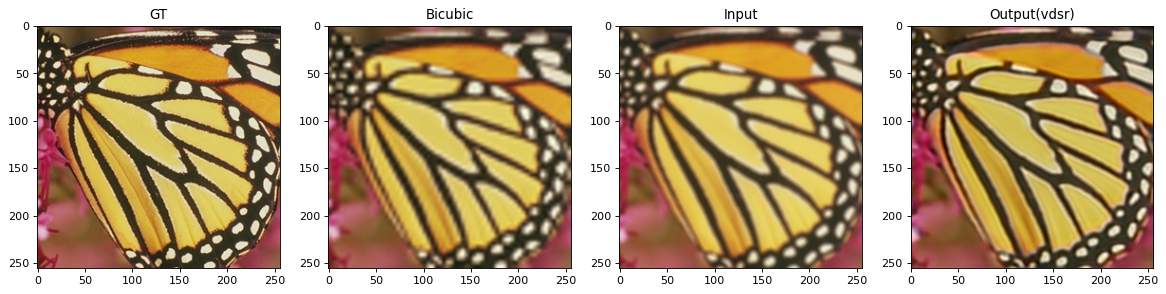

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7FD0DB393700>,
 20.824648960041763,
 14.277641222842387)

In [74]:
display_PSNR(im_gt, im_b, im_b2, model)

# convert sample videos

In [75]:
folder = "/media/SSD/superres/Results/Superresolution train vdsr with multifuz/"

infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secfuzmodel1-16.mp4"
superres_mp4(infile, outfile, model, factor=1.6,display=False,bitrate= "4000k")

  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with multifuz/muffins30secfuzmodel1-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|██████████| 900/900 [00:28<00:00, 31.72it/s]


True

In [76]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secfuzmodel1-10.mp4"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k")

  1%|          | 11/900 [00:00<00:08, 106.72it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with multifuz/muffins30secfuzmodel1-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:08<00:00, 109.97it/s]


True

In [77]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secfuzmodel1-20.mp4"
superres_mp4(infile, outfile, model, factor=2.0,display=False,bitrate= "4000k")

  0%|          | 3/900 [00:00<00:37, 23.95it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with multifuz/muffins30secfuzmodel1-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [00:38<00:00, 23.67it/s]


True

In [78]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secfuzmodel1-30.mp4"
superres_mp4(infile, outfile, model, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 2/900 [00:00<01:08, 13.16it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with multifuz/muffins30secfuzmodel1-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 900/900 [01:14<00:00, 12.15it/s]


True

In [79]:
dualfile= folder + "muffins30secfuzmodel1-30dual.mp4"

In [80]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [81]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [82]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = folder + "super8fuzmodel1.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with multifuz/super8fuzmodel1.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 7195/7195 [04:31<00:00, 26.46it/s]


True

In [83]:

dualfile= folder + "super8fuzmodel1dual.mp4"

In [84]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [85]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train vdsr with perception loss/super8percepmodel3.mp4"
outfile = folder + "super8fuzmodel1.mp4"
dualfile= folder + "super8fuzmodel1-tolast-dual.mp4"

In [86]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [87]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = folder + "super8longfuzmodel1.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with multifuz/super8longfuzmodel1.mp4
factor: 1.0 
width= 720 
height=

  0%|          | 2/121409 [00:00<1:41:52, 19.86it/s]

 480 
bitrate= 4000k


100%|██████████| 121409/121409 [1:14:53<00:00, 27.02it/s]


True

In [88]:
dualfile= folder + "super8longfuzmodel1dual.mp4"

In [89]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [ ]:
def dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file):
    
    superres_mp4(infile, outfile, model, factor=factor,display=False,bitrate="4000k",errorfile = error_file)
    
    # original scale , for film x1, removed un needed scaling
    !ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = folder + "super8percepmodel2.mp4"
outfile = folder + "super8percepmodel2x2.mp4"
dualfile= folder + "super8percepmodel2x2x1dual.mp4"
error_file = "/media/SSD/superres/error.txt"

dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file)

infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
dualfile= folder + "super8percepmodel2x2origdual.mp4"

!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}